# Speed Up Cheminformatics

### With NVIDIA® RAPIDS and Python Multiprocessing

<br>

**Author:** Marcel Baltruschat (<a href="https://github.com/mrcblt">@GitHub</a>)<br>
**Date:** 16.07.2021
<br><br><br>

### Installation with Conda

Tested on _DeepChem_ (96 cores, 377 GB RAM, 4x Nvidia GeForce RTX 2080 Ti, Ubuntu 20.04.2 LTS, x86_64)

Some packages might only be available for Linux machines.

`conda create -n rapids -c rapidsai -c nvidia -c conda-forge cudf cuml python=3.8 cudatoolkit=11.2 jupyterlab rdkit seaborn scikit-learn`
<br><br>

---


### Imports and Settings

In [1]:
% matplotlib inline

import cudf
import cuml
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from multiprocessing import Pool
from rdkit.Chem import AllChem as Chem
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from time import time

sns.set()
random_seed = 42

### Loading Example Dataset

The original dataset was published by **Ogura _et al._ (2019)** [1].<br>
The only changes made were the conversion from XLSX to CSV and the filtering out of all molecules with invalid valences.

In [2]:
df = pd.read_csv('datasets/example_dataset_hERG.csv')
print(len(df))
df.head()

190464


,Canonical_Smiles,class
0,CCOC(=O)C1CCN(CC1)C(C)C(=O)c2c(C)[nH]c3cc(C)ccc23,1
1,COc1ccc(NC(=O)N2CCC3(CCN(C)CC3)CC2)cc1F,1
2,OC1(CN(CC1CN2CCC(CC2)N(CC=C)C(=O)OCc3ccc(cc3)C...,1
3,CCOc1ccccc1OCC(=O)Nc2cc(ccc2N3CCN(CC)CC3)S(=O)...,1
4,CN(C1CCN(Cc2ccc(cc2)C(F)(F)F)CC1)C(=O)Cc3ccc(c...,1


---
### Calculating Morgan Fingerprints (FCFP6) with Multiprocessing

In [3]:
def smi_to_FCFP6(smi):
    mol = Chem.MolFromSmiles(smi)
    fp = Chem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=4096, useFeatures=True)
    ar = np.empty(4096, dtype=np.int32)
    ConvertToNumpyArray(fp, ar)
    return ar

In [4]:
t0 = time()
df.Canonical_Smiles.apply(smi_to_FCFP6)
print(f'1 core (no pool): {time() - t0:.2f}s')

1 core (no pool): 85.68s


In [5]:
for cores in [1, 2, 4, 8, 16, 32, 64]:
    with Pool(cores) as p:
        t0 = time()
        p.map(smi_to_FCFP6, df.Canonical_Smiles)
        print(f'{cores} core(s): {time() - t0:.2f}s')

1 core(s): 107.93s
2 core(s): 49.55s
4 core(s): 28.49s
8 core(s): 15.63s
16 core(s): 9.90s
32 core(s): 8.19s
64 core(s): 9.29s


#### _Rule of thumb: The more complex the single tasks are the more cores you can use_

In [6]:
num_cores = 32
with Pool(num_cores) as p:
    X_data = np.array(p.map(smi_to_FCFP6, df.Canonical_Smiles))
X_data.shape

(190464, 4096)

---
### Exploring Chemical Space with GPU

In [7]:
# Convert to CUDA DataFrame
cX_data = cudf.DataFrame(X_data, dtype=np.float32)

In [8]:
ctsne = cuml.TSNE(perplexity=50, n_neighbors=150, random_state=random_seed)
t0 = time()
cpc2 = ctsne.fit_transform(cX_data)
print(f'TSNE time: {time() - t0:.2f}s')

[W] [14:44:22.677890] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE time: 25.02s


In [9]:
# Converting result back to normal Pandas DataFrame
pc2 = cpc2.to_pandas()

In [10]:
# Get standard deviation
pc2_std = pc2.describe().loc['std']

# Find all outliers that are greater than four times the standard deviation for at least one of the two columns
outlier = np.any(list(zip(abs(pc2[0]) > pc2_std[0] * 4, abs(pc2[1]) > pc2_std[1] * 4)), axis=1)

outlier_ix = pc2.loc[outlier].index
pc2.drop(index=outlier_ix, inplace=True)
cpc2.drop(index=outlier_ix, inplace=True)

print(f'{len(outlier_ix)} outlier(s) dropped')

3 outlier(s) dropped


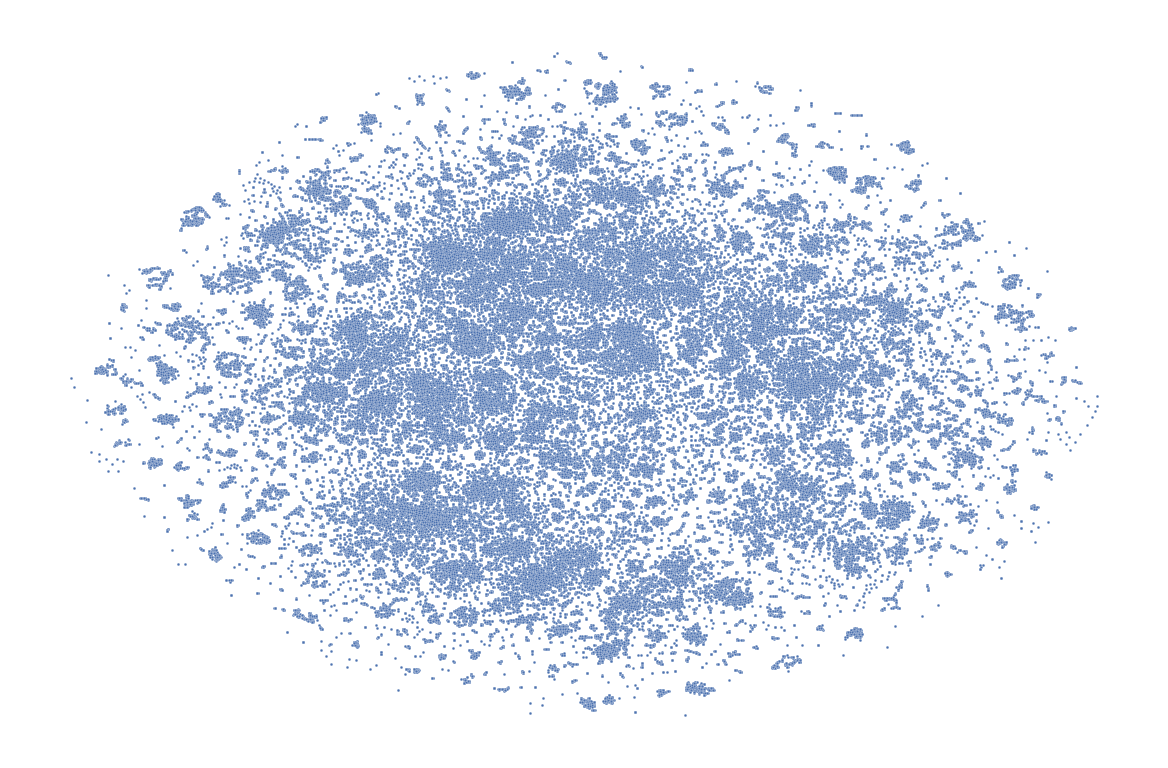

In [11]:
plt.figure(dpi=200)
sns.scatterplot(data=pc2, x=0, y=1, s=1)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Free some CPU and GPU memory

In [12]:
del ctsne
plt.close()
# Without this call GPU memory is not freed
gc.collect();

---
### Clustering with DBSCAN on GPU/CPU
#### Using principle components

In [13]:
cdbscan = cuml.DBSCAN(eps=0.75)
t0 = time()
ccluster = cdbscan.fit_predict(cpc2)
print(f'DBSCAN (GPU) clustering time: {time() - t0:.2f}s')

DBSCAN (GPU) clustering time: 2.53s


In [14]:
dbscan = DBSCAN(n_jobs=num_cores, eps=0.75)
t0 = time()
cluster = dbscan.fit_predict(pc2)
print(f'DBSCAN (CPU) clustering time: {time() - t0:.2f}s')

DBSCAN (CPU) clustering time: 0.97s


In [15]:
print(f'{len(cluster) - len((cluster == ccluster.to_array()).nonzero()[0])}/{len(cluster)} points have different clusters')

3/190461 points have different clusters


#### Visualize cluster

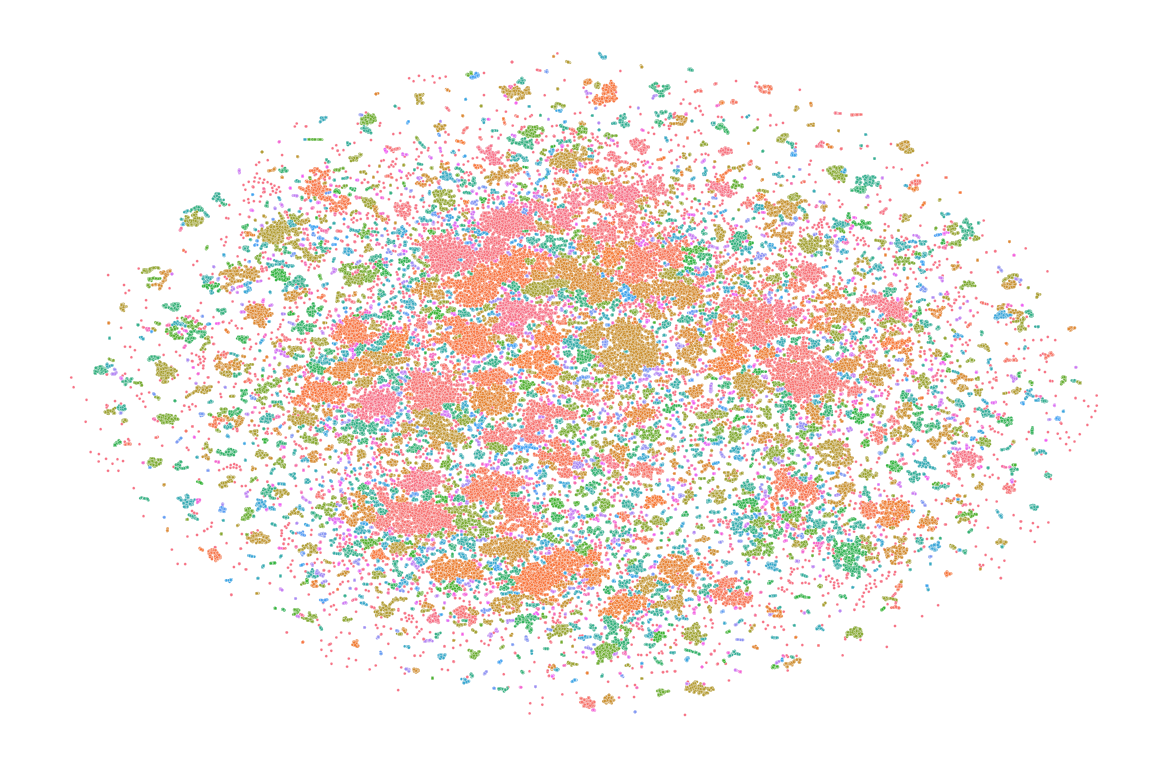

In [16]:
plt.figure(dpi=200)
sns.scatterplot(data=pc2, x=0, y=1, s=1, hue=cluster.astype(str), legend=False)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Using FCFP6

In [17]:
cdbscan2 = cuml.DBSCAN()
t0 = time()
ccluster2 = cdbscan2.fit_predict(cX_data)
print(f'DBSCAN (GPU) clustering time: {time() - t0:.2f}s')

DBSCAN (GPU) clustering time: 86.46s


In [18]:
dbscan2 = DBSCAN(n_jobs=num_cores)
t0 = time()
cluster2 = dbscan2.fit_predict(X_data)
print(f'DBSCAN (CPU) clustering time: {time() - t0:.2f}s')

DBSCAN (CPU) clustering time: 1104.20s


In [19]:
print(f'{len(cluster2) - len((cluster2 == ccluster2.to_array()).nonzero()[0])}/{len(cluster2)} points have different clusters')

0/190464 points have different clusters


#### Free some CPU and GPU memory

In [20]:
del cdbscan, ccluster, cX_data, cpc2, ccluster2, cdbscan2
# Without this call GPU memory is not freed
gc.collect();

---
### Train a Random Forest Model on GPU

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, df['class'], test_size=0.1, stratify=df['class'], random_state=random_seed)

cX_train = cudf.DataFrame(X_train, dtype=np.float32)
cX_test = cudf.DataFrame(X_test, dtype=np.float32)
cY_train = cudf.Series(Y_train, dtype=np.int32)
cY_test = cudf.Series(Y_test, dtype=np.int32)

In [22]:
crf = cuml.ensemble.RandomForestClassifier(n_estimators=1000, max_depth=64, random_state=random_seed)
t0 = time()
crf.fit(cX_train, cY_train)
print(f'RandomForest (GPU) training time: {time() - t0:.2f}s')

/home/baltrus/miniconda3/envs/rapids/lib/python3.8/site-packages/cuml/internals/api_decorators.py:794: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


RandomForest (GPU) training time: 155.18s


In [23]:
pred = crf.predict(cX_test).to_pandas()
print(f'Kappa: {cohen_kappa_score(Y_test, pred):.3f}')

Kappa: 0.533


#### Free some CPU and GPU memory

In [24]:
del cX_train, cX_test, cY_train, cY_test, crf
# Without this call GPU memory is not freed
gc.collect();

### Train a Random Forest Model on CPU (32 cores)

In [25]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=num_cores, max_depth=64, random_state=random_seed)
t0 = time()
rf.fit(X_train, Y_train)
print(f'RandomForest (CPU) training time: {time() - t0:.2f}s')

RandomForest (CPU) training time: 402.41s


In [26]:
pred = rf.predict(X_test)
print(f'Kappa: {cohen_kappa_score(Y_test, pred):.3f}')

Kappa: 0.575


---
### References
[1] Ogura, K., Sato, T., Yuki, H. et al. Support Vector Machine model for hERG inhibitory activities based on the integrated hERG database using descriptor selection by NSGA-II. Sci Rep 9, 12220 (2019). https://doi.org/10.1038/s41598-019-47536-3

### Useful Resources
- https://docs.python.org/3/library/multiprocessing.html
- http://practicalcheminformatics.blogspot.com/2020/06/wicked-fast-cheminformatics-with-nvidia.html
- https://patwalters.github.io/practicalcheminformatics/jupyter/dask/parallel/2021/03/28/dask-cheminformatics.html
- https://rapids.ai/start.html#get-rapids
- https://docs.rapids.ai/api/cudf/stable/10min.html
- https://docs.rapids.ai/api/cuml/stable/cuml_intro.html

### Disclaimer
The configurations for modelling and clustering might be suboptimal for the specific task and dataset. Since the key point of this notebook is to show the possible runtime advantage of GPU usage and the comparison of results between CPU and GPU runs, configuration optimisation was neglected.